# 🧠 Machine Learning (ML) Modeling – Energy Consumption Forecasting

In this notebook, we develop and evaluate ML models to forecast electricity demand using the processed dataset.

We aim to improve upon the baseline models (Naive and Mean) by leveraging linear regression and tree-based methods.

Models evaluated:
- Linear Regression
- Ridge Regression
- Lasso Regression
- Random Forest Regressor

## 0. 📦 Imports + Load Data

In [ ]:
# Core libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from sklearn.linear_model import LinearRegression, Ridge, Lasso  # type: ignore
from sklearn.ensemble import RandomForestRegressor  # type: ignore
import sys

sys.path.append("../")

from src.metrics.evaluation import evaluate_model
from src.visualization.plot_utils import set_plot_style

In [ ]:
# Load final feature matrix
df = pd.read_csv("../data/processed/final_features.csv", parse_dates=["datetime"])
df.dropna(inplace=True)

df.head(100000)

### 0.1 Encoding cathegorical variables

To prepare our dataset for modeling, we must encode categorical variables. These include:

- `city_name`: City of the weather record (5 categories)
- `weather_main`: General weather condition (12 categories)
- `weather_description`: Detailed condition (43 categories)
- `weather_icon`: Icon identifier with day/night suffixes (24 categories)

In [ ]:
# Finding categorical columns
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print(categorical_cols)

In [ ]:
# Finding unique values in categorical columns
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")
    print(df[col].unique()[:10], "\n")

#### 🔍 Step 1: Drop high-cardinality/redundant columns

- `weather_description` and `weather_icon` have too many distinct values for one-hot encoding.
- They also overlap semantically with `weather_main` and `hour` respectively.
- To avoid dimensionality explosion and redundancy, we **drop them**.

In [ ]:
# Drop redundant/high-cardinality categorical columns
df.drop(columns=["weather_description", "weather_icon"], inplace=True)

#### 🔄 Step 2: One-Hot Encode Reasonable Categorical Features

We apply one-hot encoding on:

- `city_name`: captures spatial information.
- `weather_main`: general condition is sufficient and easier to interpret.

We drop the first category to avoid multicollinearity.

In [ ]:
# One-hot encode reasonable categorical variables
df = pd.get_dummies(df, columns=["city_name", "weather_main"], drop_first=True)

#### 🌅 Step 3: Extract Daylight Signal

The `weather_icon` column indicates whether the observation is during the day (d) or night (n), but we drop it due to high cardinality, besides we found misleading cathegories as `01` or `10` in that feature, so we couldn't  obtain the day (d) - night (n) information from there.

Instead, we encode day/night cycles using the hour feature:

In [ ]:
# Adding is_daylight feature
df["is_daylight"] = df["hour"].apply(lambda h: 1 if 7 <= h <= 16 else 0)

- 	This reflects the daylight hours used by OpenWeather, where daylight typically runs from 07:00 to 16:59 UTC.
- This binary feature helps capture differences in energy usage between daytime and nighttime.

In [ ]:
# Export the processed DataFrame
# to a CSV file for use in modeling
# df.to_csv("../data/processed/model_ready_features.csv", index=False)

## 📅  1. Time-Based Train/Test Split

To preserve the temporal structure of the time series, we split the data chronologically:
- **Training set**: data before 2018
- **Test set**: data from 2018 onward

In [ ]:
# Time-based split
cutoff = "2018-01-01"
train = df[df["datetime"] < cutoff].copy()
test = df[df["datetime"] >= cutoff].copy()

# Feature matrix (drop datetime and target)
target = "total_load_actual"
features = [col for col in df.columns if col not in ["datetime", target]]

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

## 🧪 2. Model Training & Evaluation

We will train several models and evaluate them using:
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- R² (Coefficient of Determination)

All results will be compared against our previous baseline models.

### 🧮 2.1 Linear Regression

In [ ]:
# Initialize and train the model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict on test set
linreg_preds = linreg.predict(X_test)
linreg_preds = pd.Series(linreg_preds, index=y_test.index)

# Evaluate
evaluate_model(y_test, linreg_preds, "Linear Regression")

### 📈 2.2 Ridge Regression (L2 regularización)

In [ ]:
ridge = Ridge(alpha=1.0)  # puedes ajustar alpha después
ridge.fit(X_train, y_train)
ridge_preds = ridge.predict(X_test)

evaluate_model(y_test, ridge_preds, "Ridge Regression")

### 📉 2.3 Lasso Regression (L1 regularización)

In [ ]:
lasso = Lasso(alpha=0.1)  # valor típico, ajustable
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)
lasso_preds = pd.Series(lasso_preds, index=y_test.index)

evaluate_model(y_test, lasso_preds, "Lasso Regression")

In [ ]:
coefs = pd.Series(lasso.coef_, index=X_train.columns)
coefs.sort_values().plot(kind="barh", figsize=(10, 8))
plt.title("Feature Coefficients - Lasso Regression")
set_plot_style()
plt.show()

In [ ]:
(lasso.coef_ == 0).sum()

### 🐿️ 2.4 Random Forest Regressor (Tree-based)

This model uses an ensemble of decision trees to learn non-linear relationships between features and the target.

It can capture interactions and hierarchical patterns in the data, and also provides built-in feature importance.

In [ ]:
# Initialize and train the model
rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict on test set
rf_preds = rf.predict(X_test)
rf_preds = pd.Series(rf_preds, index=y_test.index)

# Evaluation metrics
evaluate_model(y_test, rf_preds, "Random Forest")

In [ ]:
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = feature_importance.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
plt.title("Top 20 Feature Importances – Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [ ]:
X_train = X_train.drop(columns=["total_load_forecast"])
X_test = X_test.drop(columns=["total_load_forecast"])

In [ ]:
# Initialize and train the model
rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict on test set
rf_preds = rf.predict(X_test)
rf_preds = pd.Series(rf_preds, index=y_test.index)

# Evaluation metrics
evaluate_model(y_test, rf_preds, "Random Forest")

In [ ]:
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = feature_importance.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
plt.title("Top 20 Feature Importances – Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

### 🧪 Data Leakage Exploration

During modeling, we included a feature called `total_load_forecast` which was highly correlated with the target (`total_load_actual`). This variable represents the forecasted value from another system — not available during real-time predictions.

This resulted in overly optimistic results:

- **MAE dropped significantly**
- **R² rose to near perfection**
- **Feature importance was dominated by this single variable**

We visualize this below:

📊 Feature Importance (with leakage):

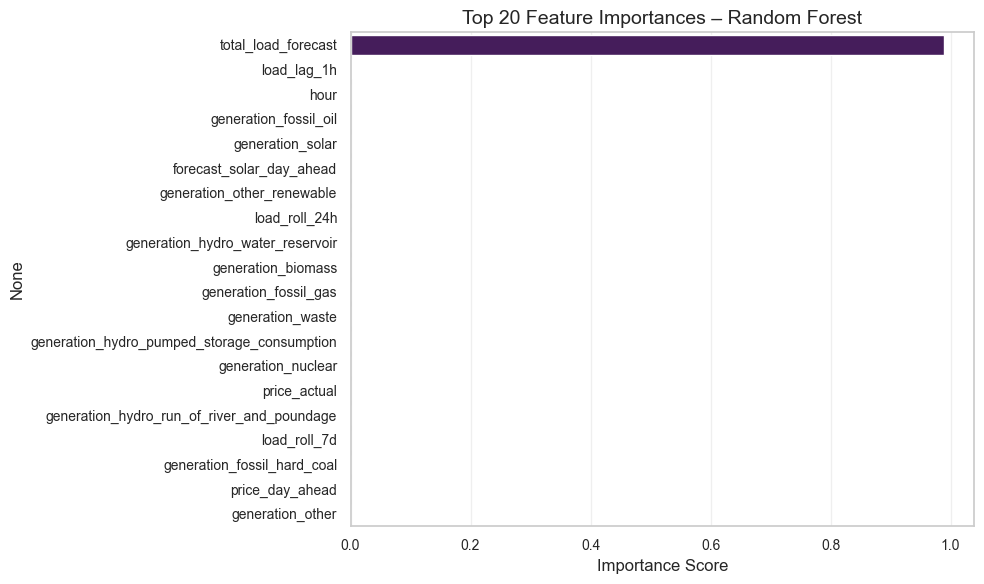

To correct for this, we dropped `total_load_forecast` and re-trained the models. As expected, performance metrics slightly decreased, but now reflect a more realistic setting.

📊 Feature Importance (corrected model):

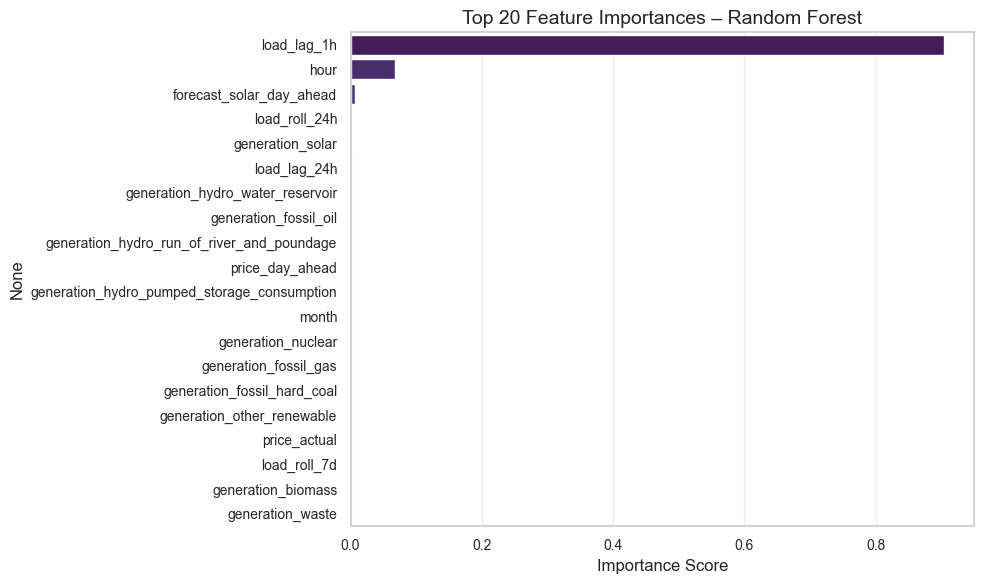

---

⚠️ This example illustrates how easily models can be misled by "future" data, and why understanding the source and availability of features is essential in time series problems.